In [1]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [2]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(102, 145, 43)

df = pd.read_csv('2017-03-16_PRO_multi_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[-43:,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)
centred_moment_5 = moment(org_values, moment=5, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((43,5))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)
out_array[:,4] = np.divide(centred_moment_5,st_dev*st_dev*st_dev*st_dev*st_dev)

print(st_dev)

print(np.mean(org_values, axis=1))
print(centred_moment_3)

# print(centred_moments.shape)


[7.02135849 6.46764834 6.65210305 6.55305272 6.44021739 6.43637126
 6.16628738 5.83888688 5.84065707 5.76935655 5.73429159 5.44024586
 5.25952469 5.21578374 5.2681567  5.27697593 4.74725184 4.64963439
 4.79335738 4.52603579 4.45772083 4.20648012 4.20871417 4.13906692
 4.1184797  4.05436801 3.70545544 3.74825293 3.61629645 3.66709694
 3.5531676  3.51574672 3.34551939 3.51448431 3.45289371 3.47455033
 3.23046436 3.16851306 3.33635655 3.09546039 2.98670387 2.8832447
 2.80141036]
[2.555 2.455 2.455 2.45  2.44  2.425 2.37  2.32  2.315 2.295 2.27  2.215
 2.18  2.16  2.155 2.145 2.06  2.03  2.035 2.    1.965 1.945 1.935 1.925
 1.925 1.89  1.86  1.84  1.82  1.82  1.8   1.795 1.75  1.78  1.755 1.75
 1.71  1.695 1.715 1.675 1.64  1.63  1.61 ]
[1504.16417025 1066.16595525 1271.13015525 1208.8965     1098.895968
 1119.13771875  953.191206    760.713336    742.99544925  721.73043225
  724.470816    597.61921425  517.638864    540.860292    558.58466025
  591.43748475  367.485732    357.964254    41

Add noise to the data (using random sampling from normal distribution)

In [3]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 5
noise_value = 25
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
noise_arr[0] = 1
noise_arr[1] = 1
noise_arr[2] = 1
noise_arr[3] = 1
noise_arr[4] = 1


Set-up pints problem and log likelihoods

In [4]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 7


Create uniform log prior

In [5]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.000001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 100
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_4974/1562655438.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [6]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 1000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.3
1     537     0:01.4
2     1038    0:02.5
3     1509    0:03.7
20    9009    0:21.0
40    15633   0:37.6
60    21801   0:53.3
80    28263   1:10.6
100   34668   1:27.6
120   41049   1:45.0
140   47508   2:02.6
160   53619   2:19.3
180   59955   2:36.6
200   66393   2:54.4
220   72780   3:11.7
240   79131   3:29.3
260   85521   3:46.5
280   91980   4:04.3
300   98502   4:22.1
320   104658   4:39.2
340   110841   4:56.3
360   117255   5:13.8
380   123543   5:30.9
400   130074   5:48.5
420   136341   6:05.9
440   143004   6:24.1
460   149508   6:42.0
480   155763   6:59.0
500   162168   7:16.4
520   168468   7:33.7
540   175035   7:51.6
560   181464   8:09.4
580   187938   8:27.3
600   194379   8:44.7
620   200913   9:02.3
640   207252   9:19.6
660   213660   9:37.1
680   220050   9:54.6
700   226269  10:11.6
720   232602  10:29.0
740   238959  10:46.4
760   245217  1

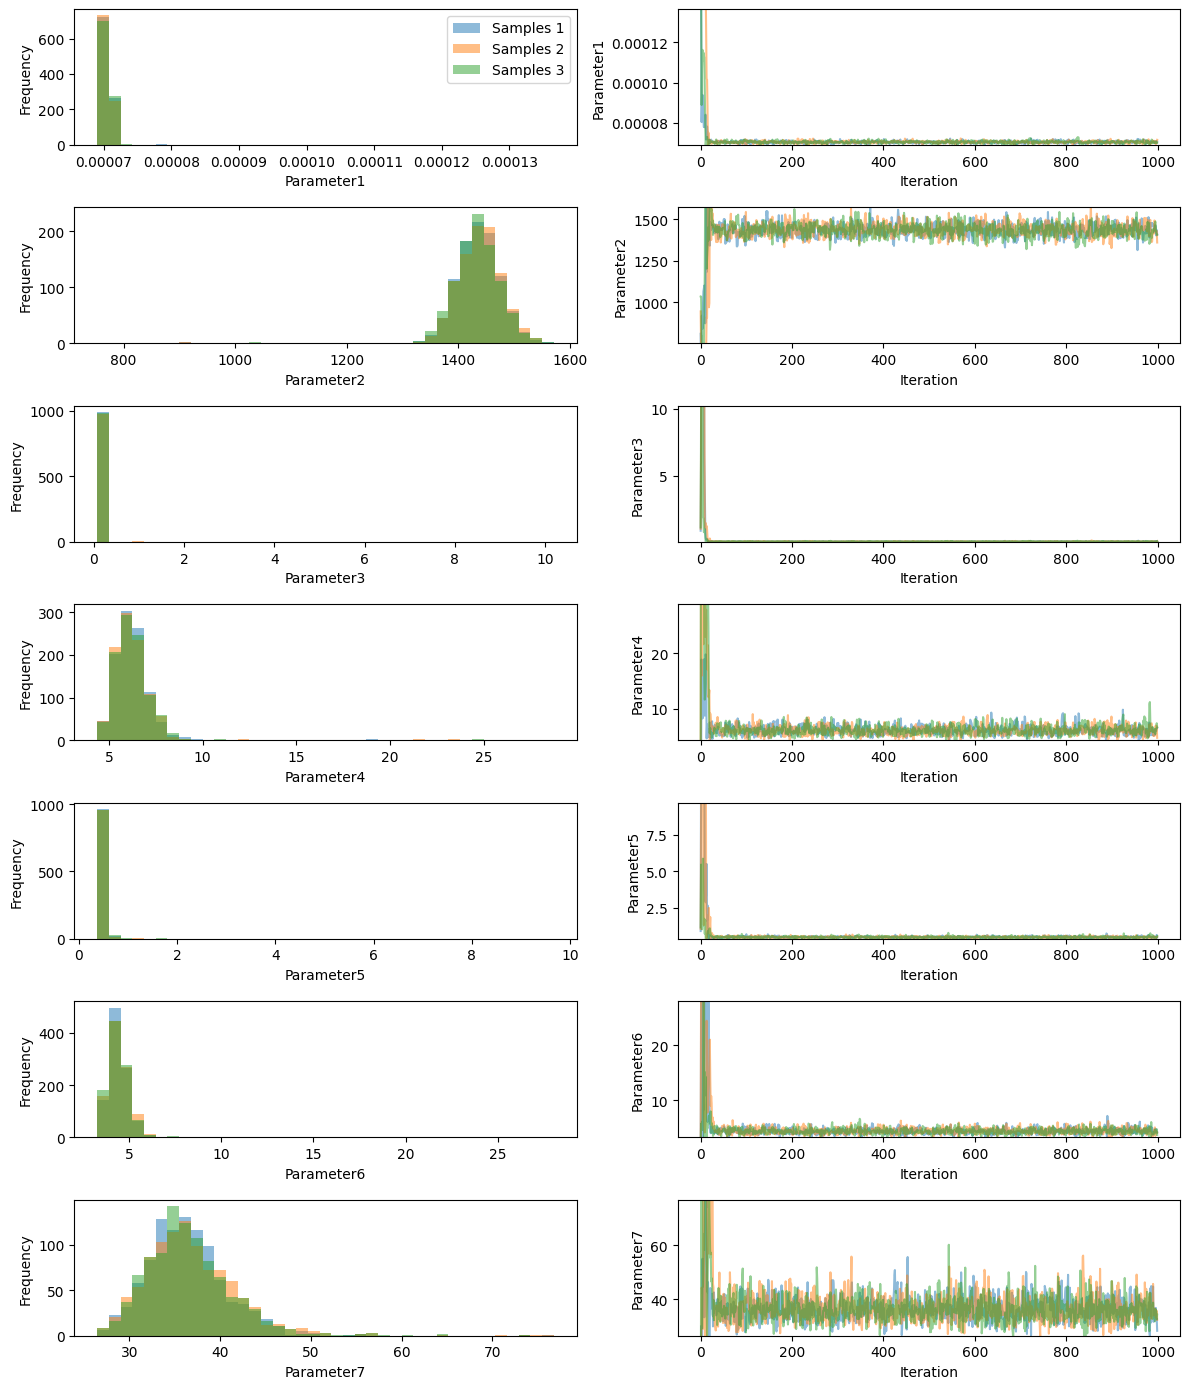

In [7]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()

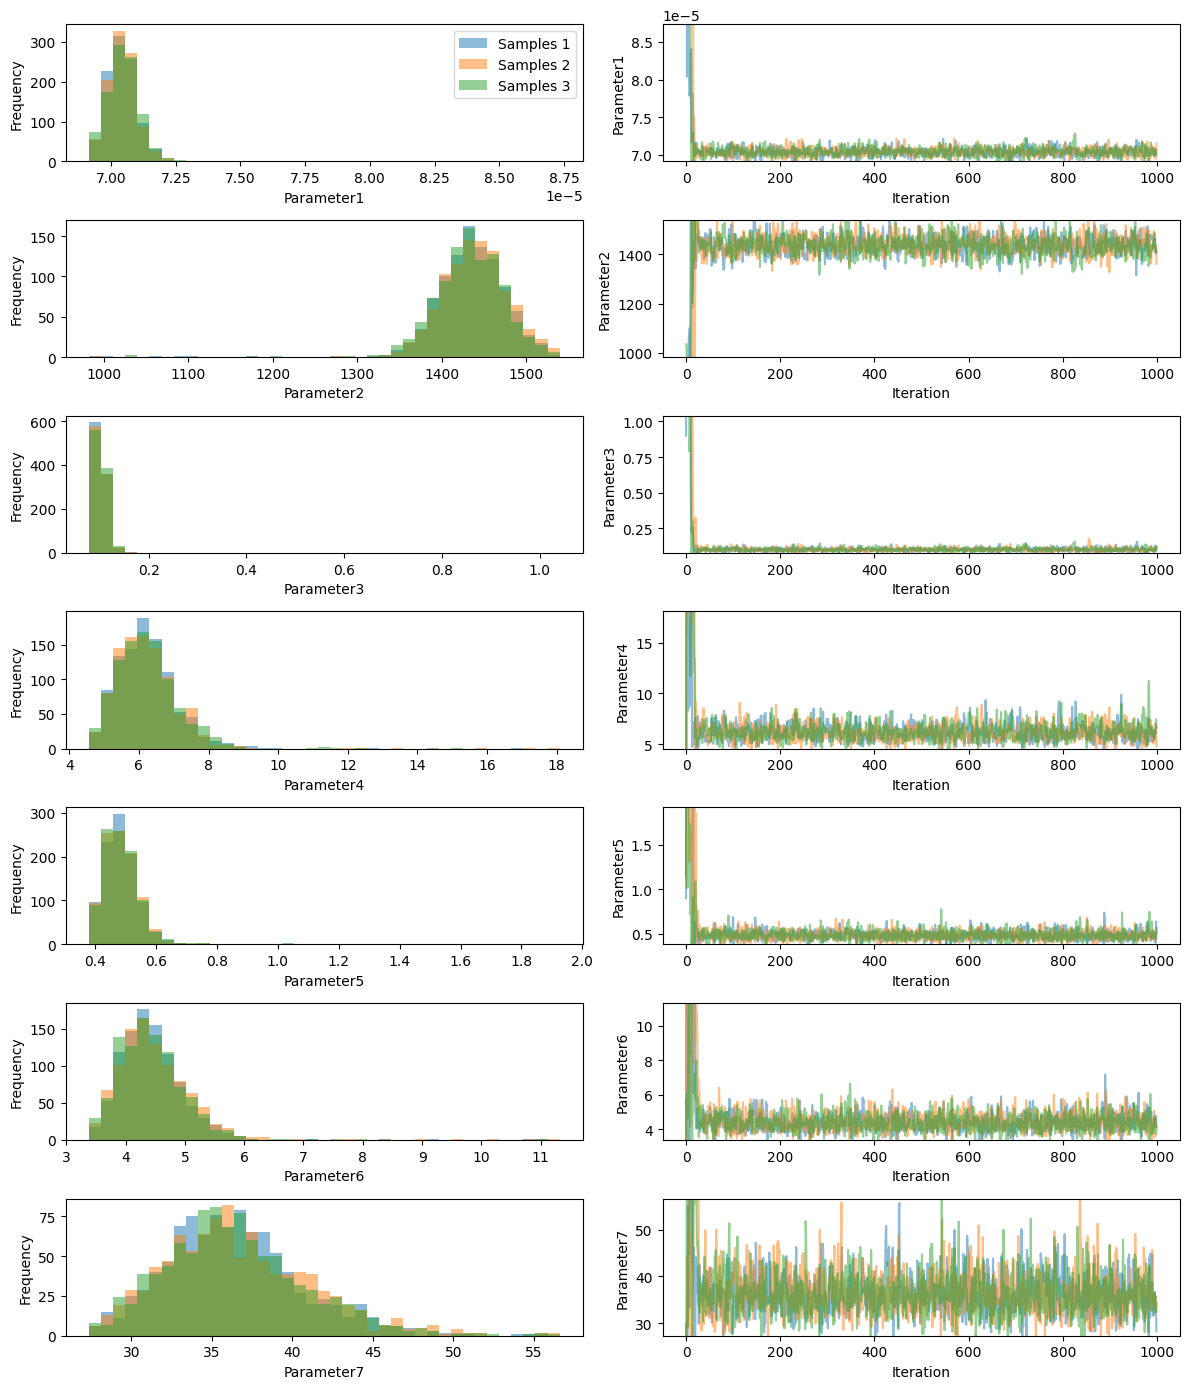

In [8]:
pints.plot.trace(chains, n_percentiles=98)
plt.savefig("mcmc.png")
plt.show()


In [9]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[6.99636482e-05 1.47852562e+03 8.81268133e-02 6.38347985e+00
 6.84798714e-01 3.98693147e+00 3.51021005e+01]
[[6.99636482e-05 1.47852562e+03 8.81268133e-02 ... 6.84798714e-01
  3.98693147e+00 3.51021005e+01]
 [6.96656940e-05 1.47981847e+03 9.26721435e-02 ... 3.59745611e-01
  5.22148288e+00 3.99435225e+01]
 [7.06918692e-05 1.43702935e+03 1.12957976e-01 ... 5.06016791e-01
  3.81191168e+00 3.94418113e+01]
 ...
 [7.07726834e-05 1.40297152e+03 1.12269616e-01 ... 3.96885962e-01
  4.62652150e+00 3.23276263e+01]
 [7.00602247e-05 1.43526501e+03 9.95591851e-02 ... 6.36082562e-01
  4.18677344e+00 3.27106220e+01]
 [7.06720135e-05 1.40992161e+03 1.17815775e-01 ... 5.07485675e-01
  4.15561391e+00 2.83002805e+01]]


In [10]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


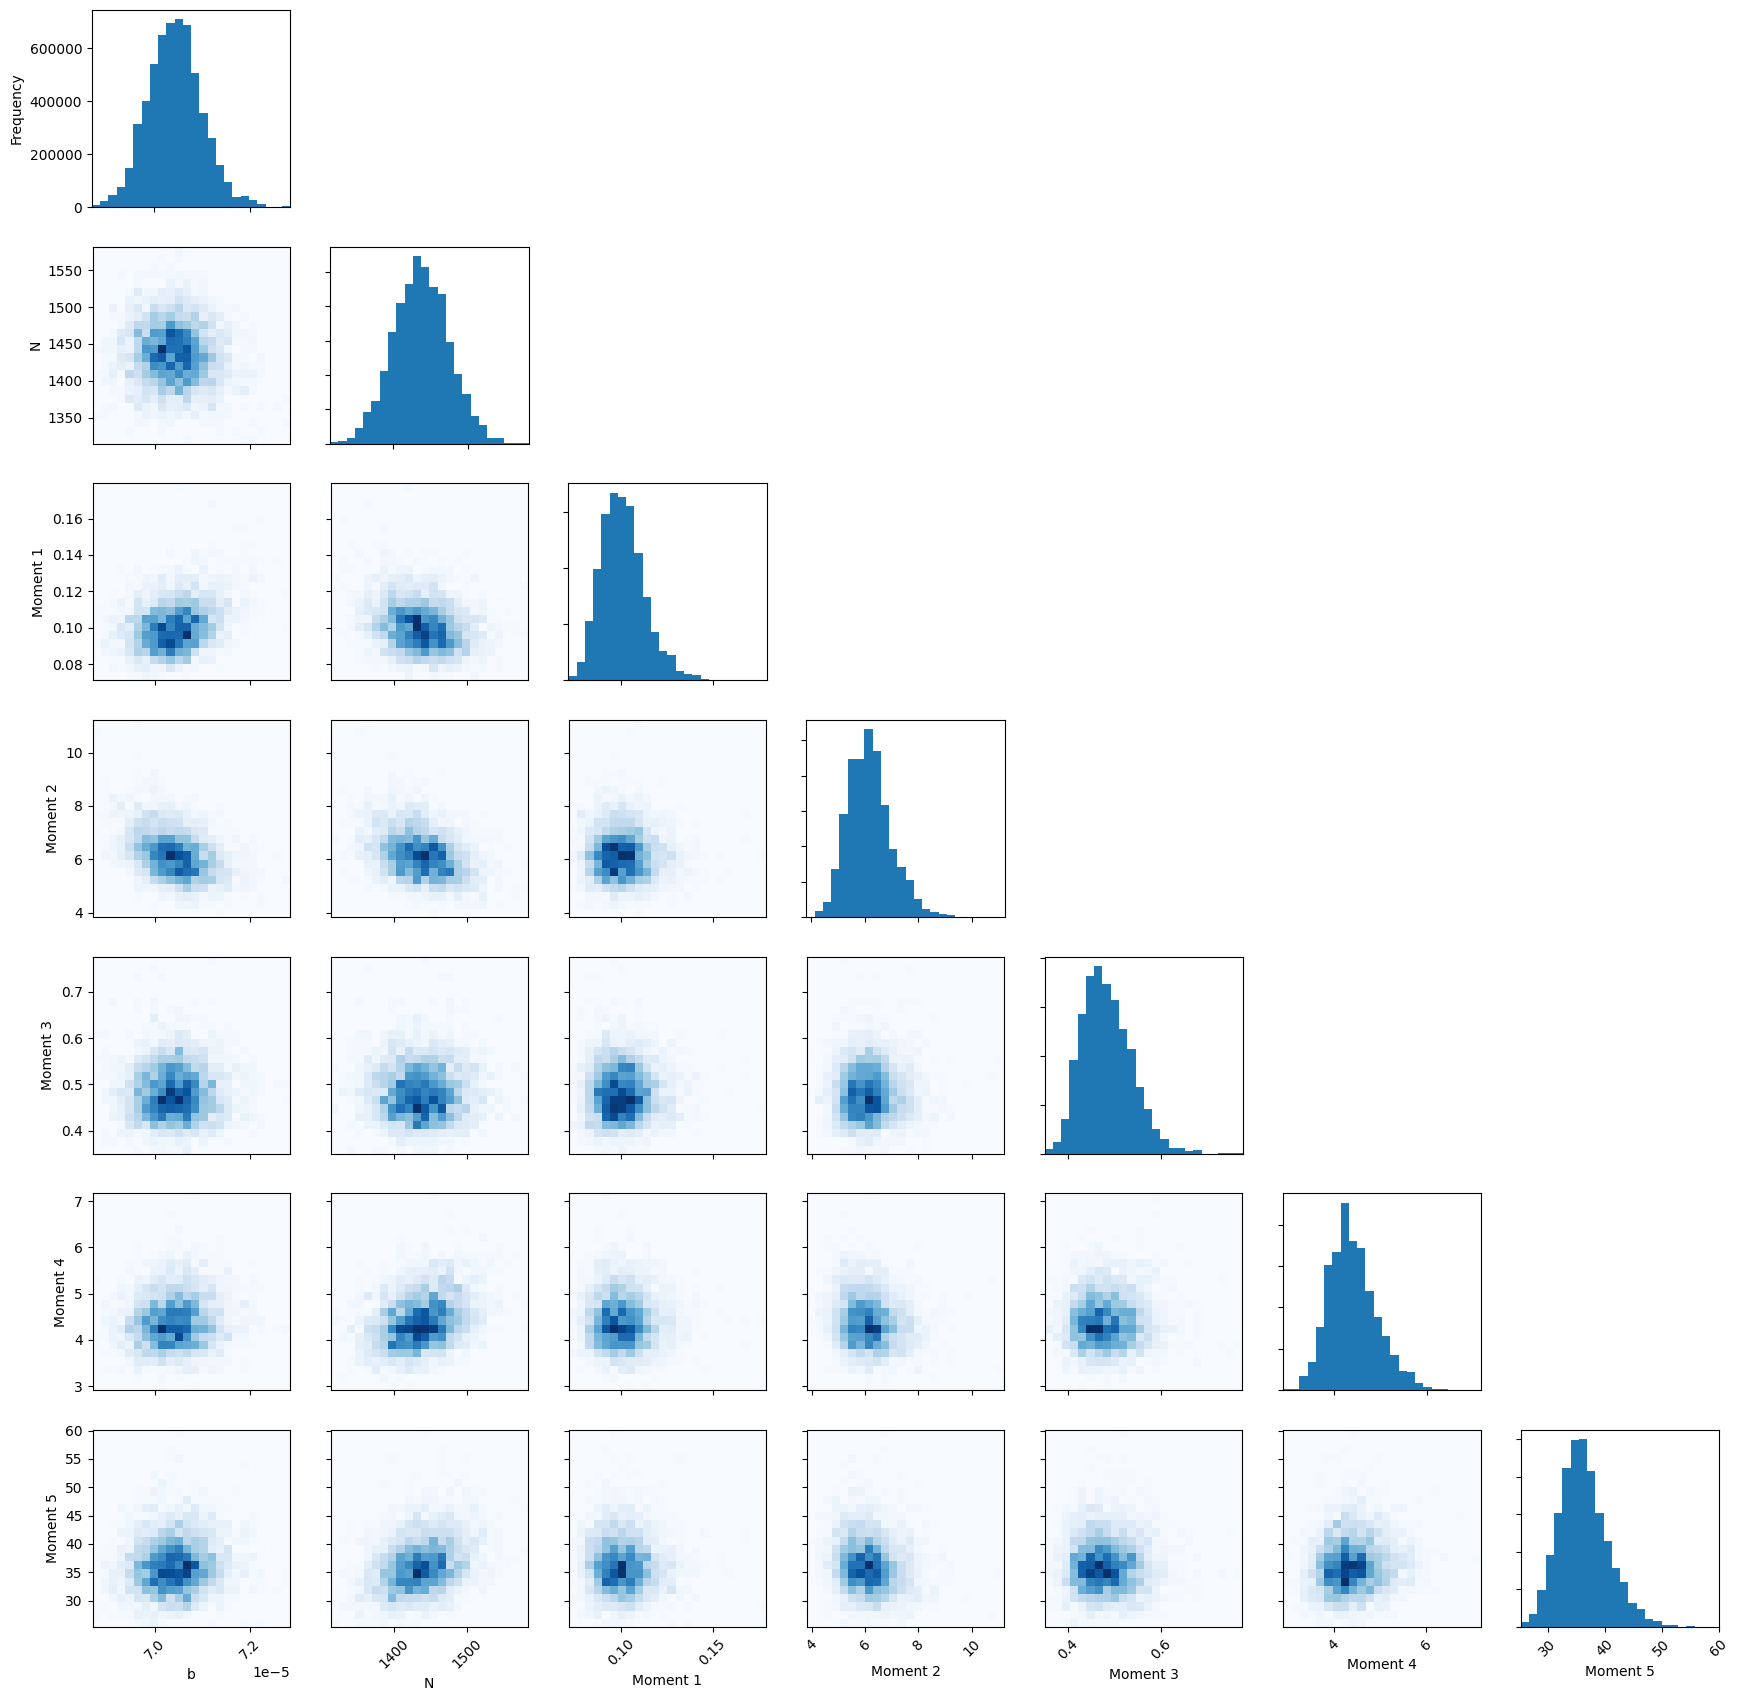

In [11]:


parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"])
plt.show()

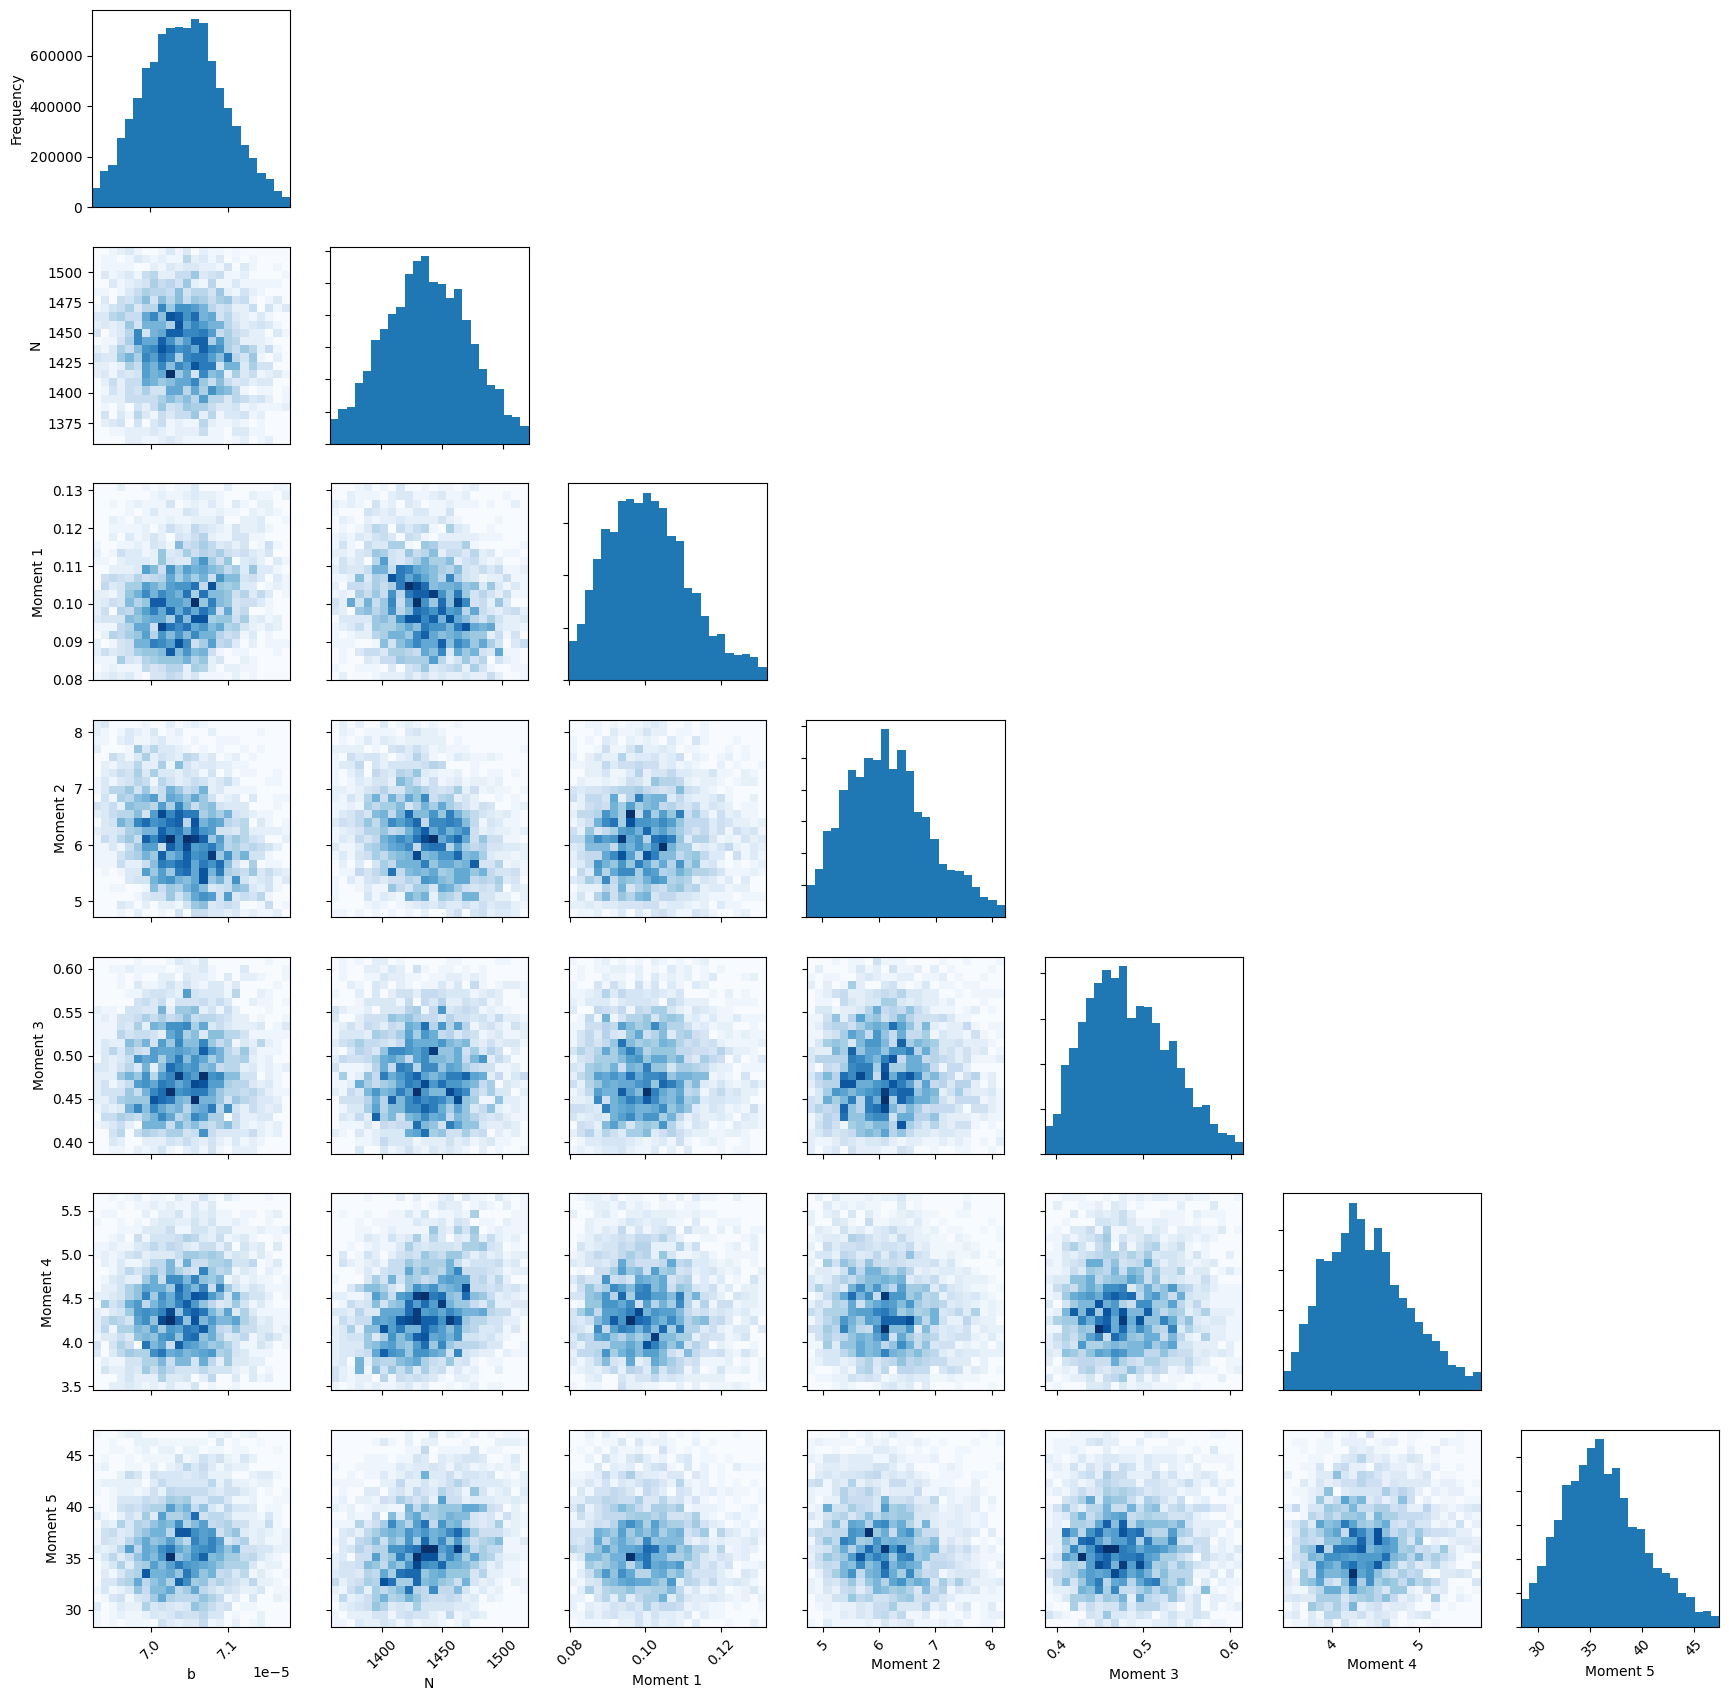

In [12]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"],
                    n_percentiles=97)
                    
plt.show()

[6.99636482e-05 1.47852562e+03 8.81268133e-02 6.38347985e+00
 6.84798714e-01 3.98693147e+00 3.51021005e+01]


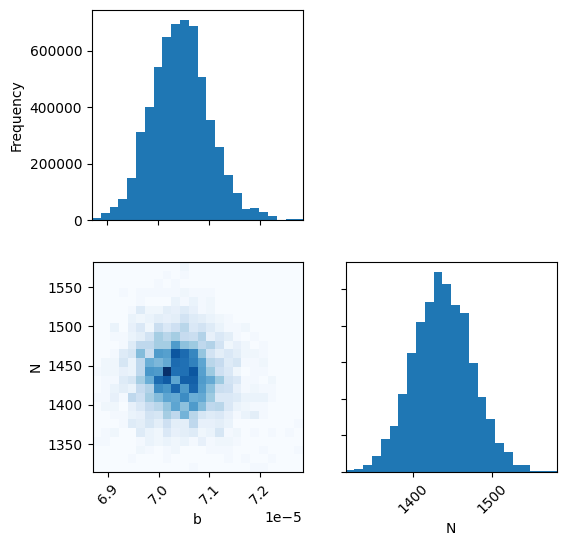

In [13]:
parameter_names = ["b","N"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1]], heatmap=True, 
                    parameter_names=["b","N"])
plt.savefig("Pints_pairwise_pro_params_only.png", dpi =300)
plt.show()


In [14]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean     std.    2.5%     25%      50%      75%      97.5%    rhat    ess     ess per sec.
--------  -------  ------  -------  -------  -------  -------  -------  ------  ------  --------------
b         0.00     0.00    0.00     0.00     0.00     0.00     0.00     1.00    363.12  0.42
N         1436.33  38.34   1360.35  1409.86  1436.25  1462.83  1510.36  1.01    366.12  0.42
Moment 1  0.10     0.01    0.08     0.09     0.10     0.11     0.13     1.00    355.06  0.41
Moment 2  6.22     0.85    4.82     5.62     6.14     6.69     8.07     1.00    347.85  0.40
Moment 3  0.48     0.05    0.39     0.44     0.48     0.52     0.60     1.00    487.84  0.56
Moment 4  4.42     0.52    3.53     4.05     4.37     4.74     5.59     1.01    432.43  0.50
Moment 5  36.40    4.57    28.67    33.22    35.99    39.07    46.54    1.00    426.70  0.49


In [15]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [16]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4", "Moment 5"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         7.04e-05  5.74e-07  6.94e-05  7e-05     7.04e-05  7.08e-05  7.16e-05  1       363    0.419
N         1.44e+03  38.3      1.36e+03  1.41e+03  1.44e+03  1.46e+03  1.51e+03  1.01    366    0.423
Moment 1  0.101     0.0127    0.0809    0.0924    0.1       0.108     0.13      1       355    0.41
Moment 2  6.22      0.855     4.82      5.62      6.14      6.69      8.07      1       348    0.402
Moment 3  0.483     0.0548    0.393     0.444     0.478     0.516     0.6       0.999   488    0.563
Moment 4  4.42      0.52      3.53      4.05      4.37      4.74      5.59      1.01    432    0.499
Moment 5  36.4      4.57      28.7      33.2      36        39.1      46.5      1       427    0.493


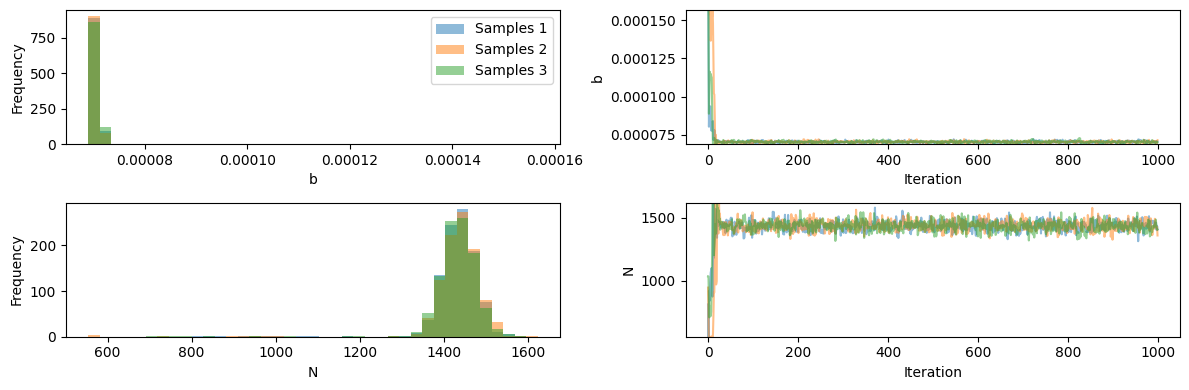

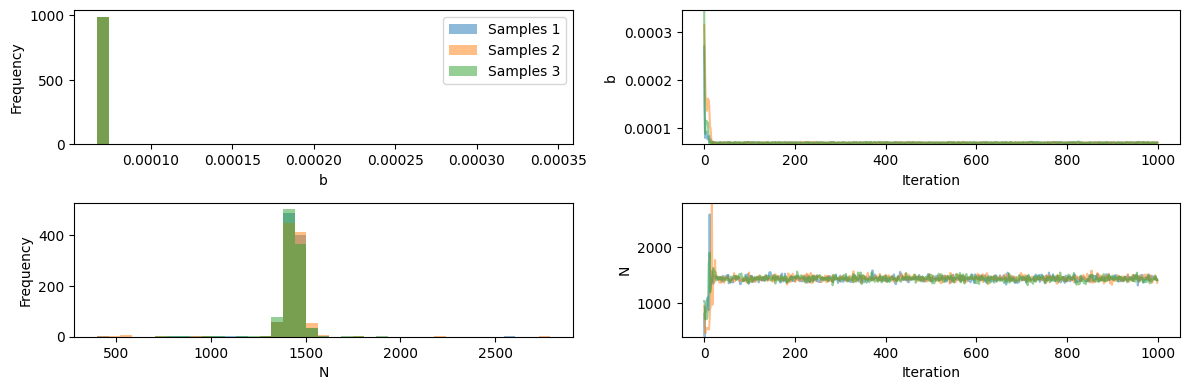

In [17]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

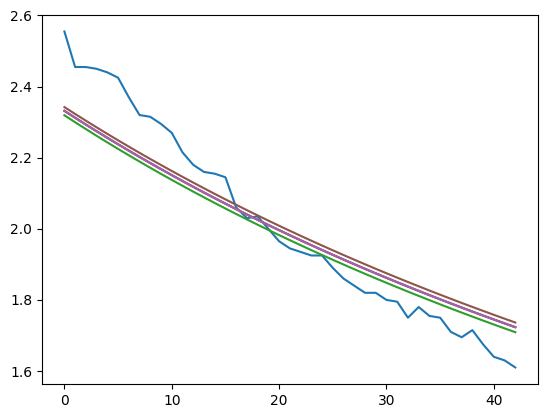

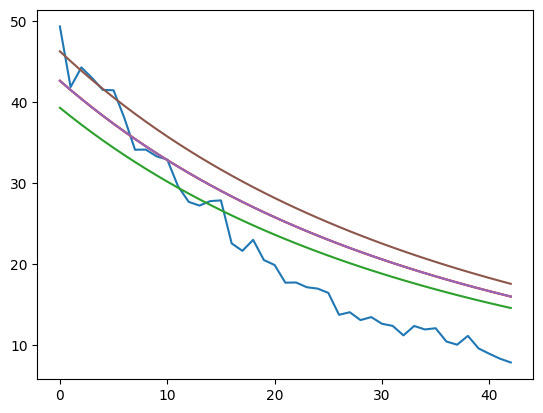

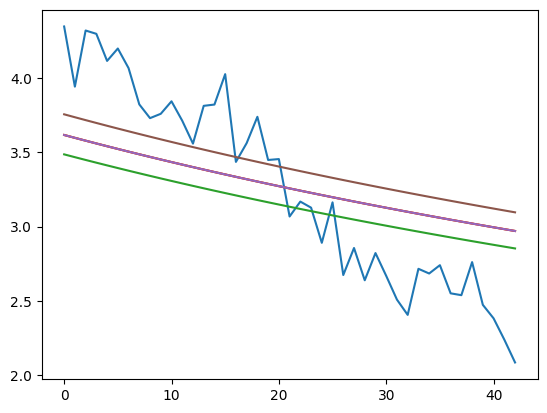

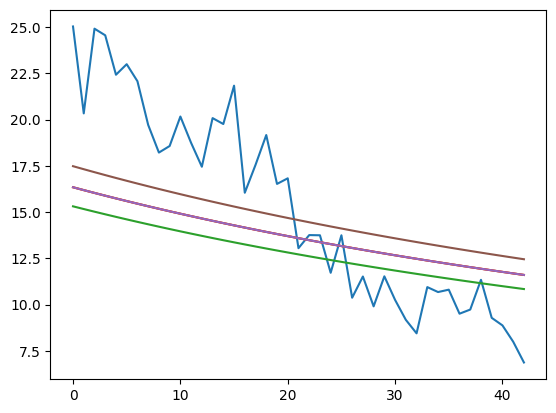

In [18]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1]]
st_devs = results.std()[[0,1]]

CI_0 = means

CI_1 = means + 2*st_devs

CI_2 = means
CI_2[0] += 2*st_devs[0]
CI_2[1] -= 2*st_devs[1] 

CI_3 = means
CI_3[0] -= 2*st_devs[0]
CI_3[1] += 2*st_devs[1] 

CI_4 = means - 2*st_devs

values_0 = model.simulate(CI_0, times)
values_1 = model.simulate(CI_1, times)
values_2 = model.simulate(CI_2, times)
values_3 = model.simulate(CI_3, times)
values_4 = model.simulate(CI_4, times)
# print(np.shape(values))

plt.plot(data_mean)
plt.plot(values_0[:,0])
plt.plot(values_1[:,0])
plt.plot(values_2[:,0])
plt.plot(values_3[:,0])
plt.plot(values_4[:,0])
plt.show()



plt.plot(data_variance)
plt.plot(values_0[:,1])
plt.plot(values_1[:,1])
plt.plot(values_2[:,1])
plt.plot(values_3[:,1])
plt.plot(values_4[:,1])
plt.show()


plt.plot(data_skewness)
plt.plot(values_0[:,2])
plt.plot(values_1[:,2])
plt.plot(values_2[:,2])
plt.plot(values_3[:,2])
plt.plot(values_4[:,2])
plt.show()

plt.plot(data_kurtosis)
plt.plot(values_0[:,3])
plt.plot(values_1[:,3])
plt.plot(values_2[:,3])
plt.plot(values_3[:,3])
plt.plot(values_4[:,3])
plt.show()

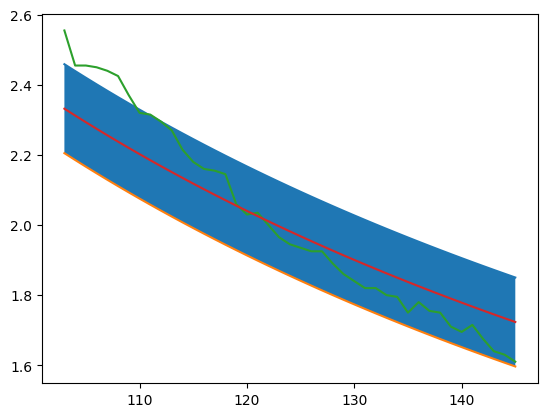

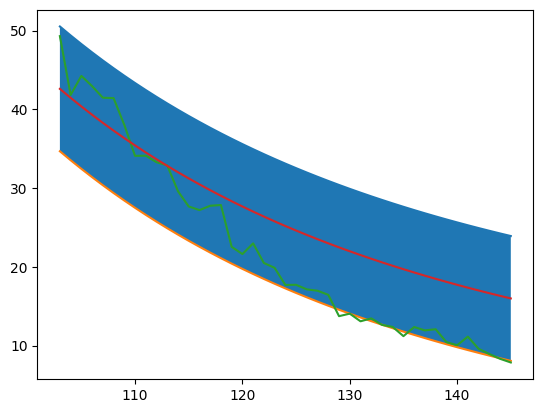

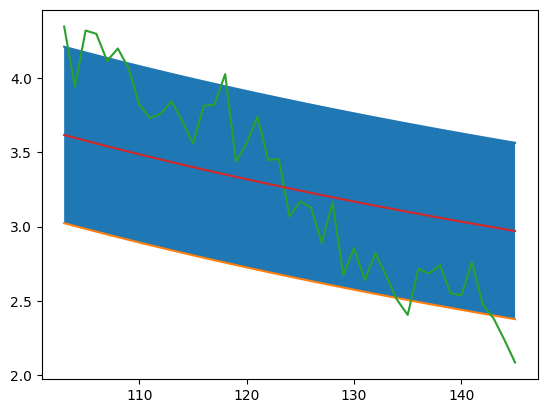

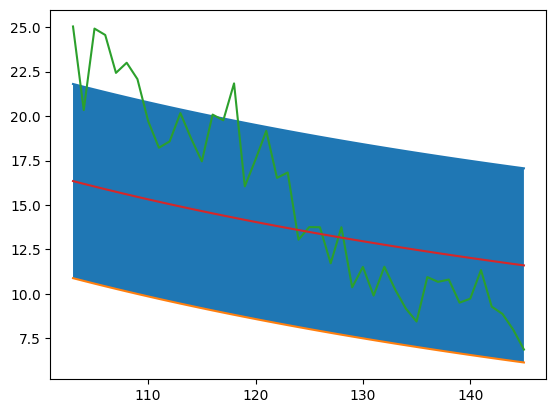

In [22]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):
means = results.mean()[[0,1]]
st_devs = results.std()[[0,1]]

mean_CI = results.mean()[[2,3,4,5]]
st_devs_CI = results.std()[[2,3,4,5]]

CI_0 = means


values_0 = model.simulate(CI_0, times)
x=np.linspace(103,145,43)

y1=values_0[:,0]+mean_CI[0]+2*st_devs_CI[0]
y2=values_0[:,0]-mean_CI[0]-2*st_devs_CI[0]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_mean)
plt.plot(x,values_0[:,0])
plt.show()

y1=values_0[:,1]+mean_CI[1]+2*st_devs_CI[1]
y2=values_0[:,1]-mean_CI[1]-2*st_devs_CI[1]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_variance)
plt.plot(x,values_0[:,1])
plt.show()

y1=values_0[:,2]+mean_CI[2]+2*st_devs_CI[2]
y2=values_0[:,2]-mean_CI[2]-2*st_devs_CI[2]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_skewness)
plt.plot(x,values_0[:,2])
plt.show()


y1=values_0[:,3]+mean_CI[3]+2*st_devs_CI[3]
y2=values_0[:,3]-mean_CI[3]-2*st_devs_CI[3]
plt.plot(x,y1)
plt.plot(x,y2)
plt.fill_between(x,y1,y2)
plt.plot(x,data_kurtosis)
plt.plot(x,values_0[:,3])
plt.show()
